In [358]:
import serial
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [359]:
!ls /dev/ttyA*

/dev/ttyACM0


In [361]:
PORT = "/dev/ttyACM0"  # Replace with your Teensy's port
BAUD_RATE = 2000000    # Must match Teensy’s baud rate
TOTAL_SAMPLES = 100000 # Desired number of samples

def collect_samples(total_samples):
    samples = b''  # Buffer for raw bytes
    with serial.Serial(PORT, BAUD_RATE, timeout=2) as ser:
        ser.write(b'S')  # Send start command to Teensy
        # Read until we have enough bytes (2 bytes per sample)
        while len(samples) < total_samples * 2:
            data = ser.read(total_samples * 2 - len(samples))
            if data:
                samples += data
            else:
                break  # Exit if no more data (with timeout)
        # Convert raw bytes to NumPy array
        result = np.frombuffer(samples, dtype=np.uint16)
        if len(result) != total_samples:
            print(f"Warning: Expected {total_samples} samples, got {len(result)}")
        return result

In [362]:
# # Example usage
# samples = collect_samples(1000000)
# np.save("samples_qd_50mm.npy", samples)

# print(f"Collected {len(samples)} samples")
# plt.plot(samples[:10000])

In [376]:
# !ls samples_qd*

In [384]:
# Save to disk
# np.save("samples40mmv2.npy", samples)

# Load from disk
samples = np.load("samples_qd_40mm.npy")

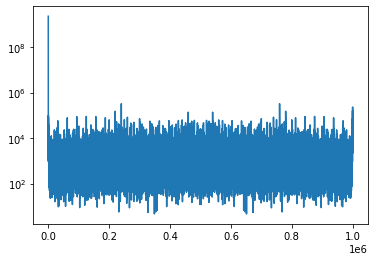

In [385]:
# FFT of the samples
spectrum = np.fft.fft(samples)
plt.figure()
plt.plot(np.abs(spectrum))
plt.yscale('log')

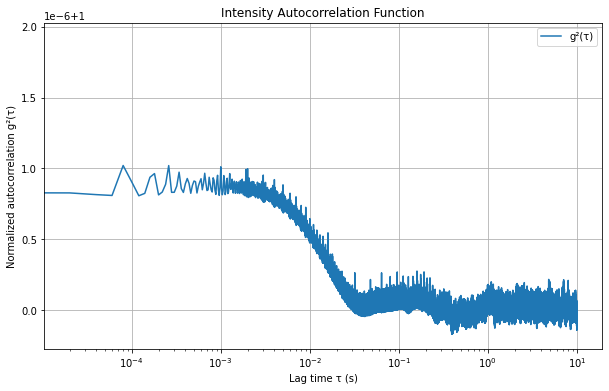

In [386]:
# Assume 'intensity' is your NumPy array with shape (1000000,)
# Replace the line below with your actual data
intensity = samples

# Parameters
N = 1000000  # Number of samples
fs = 50000   # Sampling frequency in Hz
dt = 1 / fs  # Time interval between samples (20 microseconds)

# Step 1: Compute the autocorrelation function using FFT for efficiency
I = intensity
I_fft = np.fft.fft(I)
autocorr = np.real(np.fft.ifft(I_fft * np.conj(I_fft)))[:N//2]

# Step 2: Normalize the autocorrelation function
mean_I = np.mean(I)
g2 = autocorr / (N * mean_I**2)

# Step 3: Define lag times tau
tau = np.arange(len(autocorr)) * dt  # tau in seconds

# Step 4: Plot g^2(tau) vs. tau for visualization
plt.figure(figsize=(10, 6))
plt.semilogx(tau, g2, label='g²(τ)')
plt.xlabel('Lag time τ (s)')
plt.ylabel('Normalized autocorrelation g²(τ)')
plt.title('Intensity Autocorrelation Function')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_84624/67486498.py:9: RuntimeWarning: overflow encountered in exp
  return B + A * np.exp(-2 * Gamma * tau)


Fitted parameters:
Baseline B = 1.0000
Amplitude A = 0.0000
Decay rate Γ = 35.49 s^-1


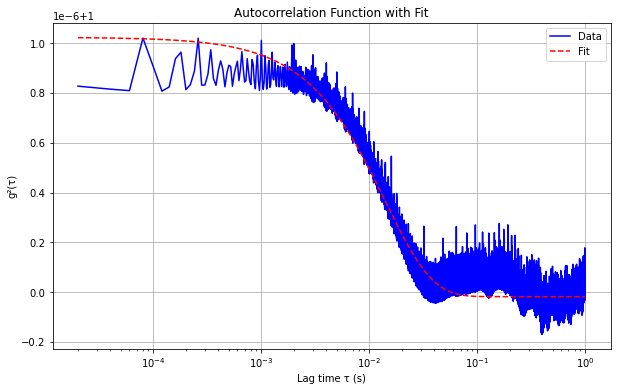

Scattering angle θ = 1.32°
Diffusion coefficient D = 2.60e-10 m²/s
Estimated particle diameter d = 1.60e-09 m (1.60 nm)


In [390]:

# Step 5: Define the fitting function for g^2(tau)
def g2_func(tau, B, A, Gamma):
    """
    Fitting function: g^2(tau) = B + A * exp(-2 * Gamma * tau)
    - B: Baseline (should be close to 1)
    - A: Amplitude (coherence factor β)
    - Gamma: Decay rate (s^-1)
    """
    return B + A * np.exp(-2 * Gamma * tau)

# Step 6: Fit g^2(tau) to the model
# Choose a fitting range (e.g., tau < 0.01 s) based on expected decay time
mask = (5e-7 < tau) & (tau < 1)  # Adjust if necessary after inspecting the plot
p0 = [1, 1, 1000]  # Initial guesses: B=1, A=1, Gamma=1000 s^-1
try:
    popt, pcov = curve_fit(g2_func, tau[mask], g2[mask], p0=p0)
    B, A, Gamma = popt
    print(f"Fitted parameters:")
    print(f"Baseline B = {B:.4f}")
    print(f"Amplitude A = {A:.4f}")
    print(f"Decay rate Γ = {Gamma:.2f} s^-1")
except RuntimeError:
    print("Fitting failed. Try adjusting the fitting range or initial guesses.")
    exit()

# Step 7: Plot the fitted curve for verification
g2_fit = g2_func(tau[mask], *popt)
plt.figure(figsize=(10, 6))
plt.semilogx(tau[mask], g2[mask], 'b-', label='Data')
plt.semilogx(tau[mask], g2_fit, 'r--', label='Fit')
plt.xlabel('Lag time τ (s)')
plt.ylabel('g²(τ)')
plt.title('Autocorrelation Function with Fit')
plt.grid(True)
plt.legend()
plt.show()

# Step 8: Compute the diffusion coefficient D
# Scattering vector q = (4 * π * n / λ) * sin(θ/2)
n = 1.33              # Refractive index of water
lambda_ = 520e-9    # Wavelength in meters (GREEN LASER)
# theta = 90 * np.pi / 180  # Scattering angle in radians
theta = np.arctan(40/1741)  # Scattering angle in radians
print(f"Scattering angle θ = {theta * 180 / np.pi:.2f}°")
q = (4 * np.pi * n / lambda_) * np.sin(theta / 2)
D = Gamma / (q**2)    # Diffusion coefficient in m^2/s
print(f"Diffusion coefficient D = {D:.2e} m²/s")

# Step 9: Compute particle diameter using Stokes-Einstein relation
k_B = 1.380649e-23    # Boltzmann's constant (J/K)
# T = 298               # Temperature in K
T = 12 + 273.15
eta = 0.001           # Viscosity in Pa·s
d = k_B * T / (3 * np.pi * eta * D)  # Diameter in meters
print(f"Estimated particle diameter d = {d:.2e} m ({d*1e9:.2f} nm)")

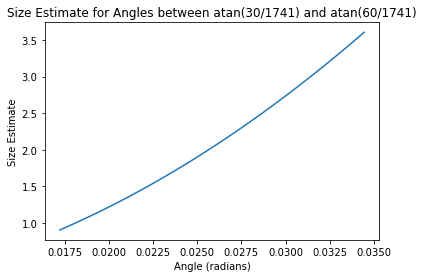

In [394]:
# For different scattering angles, your size estimate will vary:
theta_start = np.arctan(30/1741)
theta_end = np.arctan(60/1741)
theta_range = np.linspace(theta_start, theta_end, 100)
size_estimate = []
for theta in theta_range:
    q = (4 * np.pi * n / lambda_) * np.sin(theta / 2)
    D = Gamma / (q**2)
    d = k_B * T / (3 * np.pi * eta * D)
    size_estimate.append(d * 1e9)  # Convert to nanometers
plt.plot(theta_range, size_estimate)
plt.xlabel('Angle (radians)')
plt.ylabel('Size Estimate')
plt.title('Size Estimate for Angles between atan(30/1741) and atan(60/1741)');